# Парсер HeadHunter

### Импорт библиотек

In [31]:
import requests
import pandas as pd
import numpy as np

import json

from datetime import datetime, timedelta
import time
import os
from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets
from typing import Union

import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

### Выгрузка из HeadHunter

API HH: https://github.com/hhru/api \
Язык запросов HH: https://hh.ru/article/1175 \

Фильтрацию можно делать в самом запросе, например, сделать поиск по полю компаний или же по наличию конкретного текста в описании, где COMPANY_NAME - название компании, а DESCRIPTION - описание вакансии. Язык запросов работает и на обычном сайте hh.ru, что бывает полезно.



Создадим необходимые константы.

In [32]:
BASE_URL = "https://api.hh.ru/"

#TEXT = f'NAME:("Machine Learning Engineer" OR "Data Scientist" OR "Дата саентист" OR "Machine Learning Developer" or "Machine Learning Researcher" or "Искусственный интеллект" or "Машинное обучение" or "Специалист по machine learning" or "Специалист по машинному обучению" or "AI engineer" or "Разработчик ML" or "Data Science" or "Machine Learning" or "Artificial Intelligence" or "ML Engineer" or "Аналитик" or "Analyst" or "Data Engineer" or "DWH" or "BI" or "Business Intelligence" or "Data инженер" or "Инженер данных" or "ETL" or "КХД")'
TEXT = f'SQL NAME:("Аналитик" or "Analyst" or "DWH" or "BI" or "Business Intelligence" or "ETL" or "КХД")'

dt_now = datetime.now().date()
dt_from = dt_now - timedelta(days=7)
DATE_TO = dt_now.isoformat() #API требует дату в формате ISO 8601 YYYY-MM-DD или YYYY-MM-DDThh:mm:ss±hhmm
DATE_FROM = dt_from.isoformat()

VAC_URL = BASE_URL + f'vacancies?text={TEXT}&date_from={DATE_FROM}&date_to={DATE_TO}&responses_count_enabled=True&per_page=100'

В выдаче API HH нет опыта работы. Укажем его в запросе самостоятельно.

In [33]:
# 'noExperience', 'between1And3', 'between3And6', 'moreThan6'
EXPERIENCES = ['noExperience',
               'between1And3',
               'between3And6']

Цикл для направления запросов к API.

In [34]:
# Датафрейм в который будем сохранять наши данные
vacancy_df = pd.DataFrame()

# Цикл
for exp in EXPERIENCES:
    page = 0
    url = VAC_URL + f'&experience={exp}'
    try:
        r = requests.get(url + f'&page={page}')
        data = json.loads(r.text)
        print(exp, ' - ', data['pages'])
        items = data['items']
        for page in range(1, data['pages']):
            r = requests.get(url + f'&page={page}')
            data = json.loads(r.text) 
            items += data['items']
        df = pd.DataFrame(items)
        df['experience'] = exp
        vacancy_df = pd.concat([vacancy_df, df])
    except Exception as e:
        print(exp, ' - ', e)
        time.sleep(1)

noExperience  -  1
between1And3  -  12
between3And6  -  8


Загруженные данные.

In [35]:
vacancy_df.reset_index(drop=True, inplace=True)
vacancy_df.head(5)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience
0,69982637,False,Разработчик DWH,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Профсоюзная улиц...",...,"{'id': '3131901', 'name': 'РСХБ-Интех', 'url':...",{'requirement': '...языков <highlighttext>SQL<...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",{'responses': 8},[],[],[],False,noExperience
1,70025793,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Головинское шосс...",...,"{'id': '78638', 'name': 'Тинькофф', 'url': 'ht...",{'requirement': 'Понимание 6037-У (расчет МПЛ)...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 8},[],[],[],False,noExperience
2,70057994,False,Аналитик (стажёр),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Большая Новодмит...",...,"{'id': '2733062', 'name': 'Лига Цифровой Эконо...",{'requirement': 'Понимание методологий проекти...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],False,noExperience
3,69624831,False,Младший аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 50000, 'to': 55000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '1747647', 'name': 'mnews', 'url': 'htt...",{'requirement': 'Ищем специалиста по Excel с н...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 412},[],[],[],False,noExperience
4,70029179,False,Бизнес аналитик/Data аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 150000, 'to': 170000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '1424', 'name': 'Odgers Berndtson', 'ur...",{'requirement': 'Понимание <highlighttext>SQL<...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 26},[],[],[],False,noExperience


In [36]:
vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951 entries, 0 to 1950
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1951 non-null   object
 1   premium                   1951 non-null   bool  
 2   name                      1951 non-null   object
 3   department                321 non-null    object
 4   has_test                  1951 non-null   bool  
 5   response_letter_required  1951 non-null   bool  
 6   area                      1951 non-null   object
 7   salary                    402 non-null    object
 8   type                      1951 non-null   object
 9   address                   1026 non-null   object
 10  response_url              0 non-null      object
 11  sort_point_distance       0 non-null      object
 12  published_at              1951 non-null   object
 13  created_at                1951 non-null   object
 14  archived                

### Выбор ценной информации из словарей

In [37]:
def return_id(x, key='id', nan_value=np.nan):
    try:
        return x[key]
    except Exception as e:
        return nan_value

vacancy_df['employer_name']   = vacancy_df['employer'].apply(return_id, key='name')
vacancy_df['department_name'] = vacancy_df['department'].apply(return_id, key='name')
vacancy_df['salary_from']     = vacancy_df['salary'].apply(return_id, key='from')
vacancy_df['salary_to']       = vacancy_df['salary'].apply(return_id, key='to')
vacancy_df['salary_gross']    = vacancy_df['salary'].apply(return_id, key='gross')
vacancy_df['salary_currency'] = vacancy_df['salary'].apply(return_id, key='currency')
vacancy_df['response']        = vacancy_df['counters'].apply(return_id, key='response')
vacancy_df['city']            = vacancy_df['area'].apply(return_id, key='name')

vacancy_df.head(5)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,response,city
0,69982637,False,Разработчик DWH,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Профсоюзная улиц...",...,False,noExperience,РСХБ-Интех,NaN,NaN,NaN,NaN,NaN,NaN,Москва
1,70025793,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Головинское шосс...",...,False,noExperience,Тинькофф,NaN,NaN,NaN,NaN,NaN,NaN,Москва
2,70057994,False,Аналитик (стажёр),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Большая Новодмит...",...,False,noExperience,Лига Цифровой Экономики,NaN,NaN,NaN,NaN,NaN,NaN,Москва
3,69624831,False,Младший аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 50000, 'to': 55000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",None,...,False,noExperience,mnews,NaN,50000.0,55000.0,False,RUR,NaN,Москва
4,70029179,False,Бизнес аналитик/Data аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 150000, 'to': 170000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}",None,...,False,noExperience,Odgers Berndtson,NaN,150000.0,170000.0,True,RUR,NaN,Москва


### Дубликаты

Найдем вакансии с дублированными значениями работодателя, профессии, города и требуемого опыта работы.

In [38]:
vacancy_df[vacancy_df.duplicated(['employer_name', 'name', 'city'], keep=False)][['employer_name', 'name', 'city', 'experience']].sort_values(by='name')

,employer_name,name,city,experience
1342,WILDBERRIES,BI Developer,Москва,between3And6
1344,WILDBERRIES,BI Developer,Москва,between3And6
190,WILDBERRIES,BI аналитик,Москва,between1And3
193,WILDBERRIES,BI аналитик,Москва,between1And3
478,"585, Холдинг",CRM аналитик,Санкт-Петербург,between1And3
...,...,...,...,...
977,"МАГНИТ, Розничная сеть","Системный аналитик (мобильное приложение, remote)",Казань,between1And3
1483,Газпром нефть,Системный аналитик DWH,Санкт-Петербург,between3And6
1190,Газпром нефть,Системный аналитик DWH,Санкт-Петербург,between3And6
1008,Займ-Экспресс,Скоринг-аналитик / Data scientist / Аналитик (...,Москва,between1And3


Дубликатов относительно немного.

Пример дублированных вакансий. Некоторые из них имеют одинаковый id, некоторые &mdash; нет.

In [39]:
try:
    display(vacancy_df.loc[[1376, 1375]])
except Exception as e:
    print('Индексы вне допустимого диапазона') 

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,response,city
1376,70051545,False,Аналитик по розничным продуктам (потребительск...,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,False,between3And6,БАНК УРАЛСИБ,NaN,NaN,NaN,NaN,NaN,NaN,Москва
1375,70040084,False,Руководитель веб и продуктовой аналитики,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Софийская набере...",...,False,between3And6,СберМегаМаркет,NaN,NaN,NaN,NaN,NaN,NaN,Москва


### Компании и города

Топ-10 компаний по количеству вакансий.

In [40]:
vacancy_df['employer_name'].value_counts(normalize=False).head(10)

СБЕР                                65
Тинькофф                            44
Иннотех, Группа компаний            31
МТС                                 29
МАГНИТ, Розничная сеть              27
Яндекс                              25
Самокат (ООО Умное пространство)    24
Промсвязьбанк                       22
билайн                              21
Лига Цифровой Экономики             21
Name: employer_name, dtype: int64

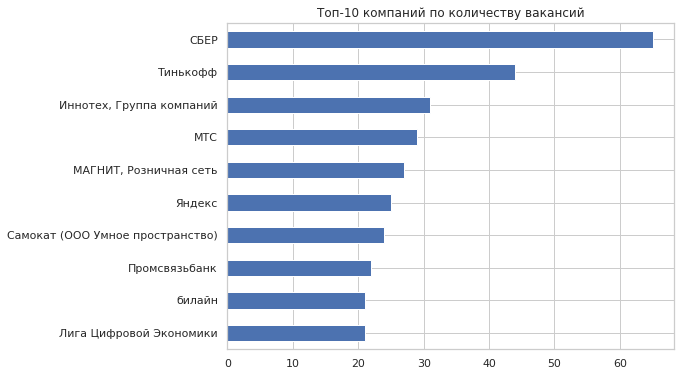

In [41]:
ax = vacancy_df['employer_name'].value_counts(normalize=False).head(10).plot.barh(figsize=(8, 6))
ax.invert_yaxis()
ax.set_title('Топ-10 компаний по количеству вакансий')
plt.show()

Топ-10 отделов компаний по количеству вакансий.

In [42]:
vacancy_df['department_name'].value_counts().head(10)

Сбер для экспертов                         36
Сбер. IT                                   25
«МТС», IT                                  16
Газпромбанк                                16
О’КЕЙ "Федеральный офис"                   15
ПАО «Газпром нефть»                        14
билайн: ИТ, Data, Digital                  13
Компания «СПОРТМАСТЕР», Sportmaster Lab    13
«МТС»                                      12
НОРБИТ                                     10
Name: department_name, dtype: int64

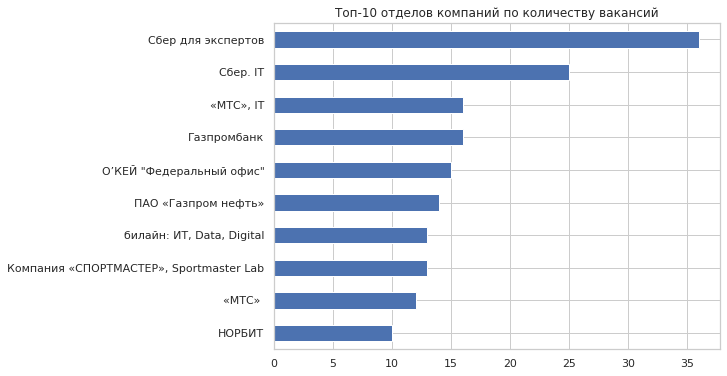

In [43]:
ax = vacancy_df['department_name'].value_counts().head(10).plot.barh(figsize=(8, 6))
ax.invert_yaxis()
ax.set_title('Топ-10 отделов компаний по количеству вакансий')
plt.show()

Топ-10 городов по вакансиям.

In [44]:
vacancy_df['city'].value_counts().head(10)

Москва             1175
Санкт-Петербург     232
Екатеринбург         57
Казань               46
Минск                38
Краснодар            36
Алматы               35
Новосибирск          32
Нижний Новгород      31
Воронеж              24
Name: city, dtype: int64

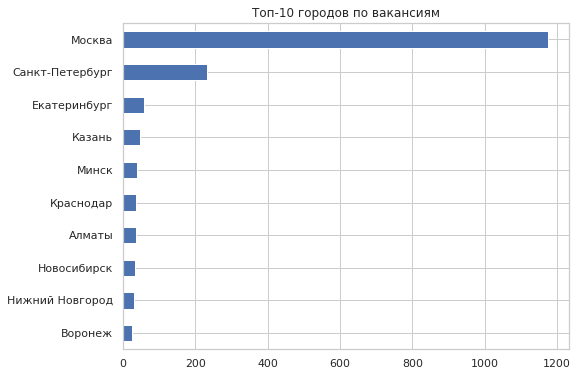

In [45]:
ax = vacancy_df['city'].value_counts().head(10).plot.barh(figsize=(8, 6))
ax.invert_yaxis()
ax.set_title('Топ-10 городов по вакансиям')
plt.show()

### Зарплата

In [46]:
vacancy_df['salary_from'].isna().value_counts(normalize=True)

True     0.835469
False    0.164531
Name: salary_from, dtype: float64

Доли вакансий с указанной и не указанной верхними границами зарплаты.

In [47]:
vacancy_df['salary_to'].isna().value_counts(normalize=True)

True     0.875961
False    0.124039
Name: salary_to, dtype: float64

Доли валют, в которых выплачивается зарплата.

In [48]:
vacancy_df['salary_currency'].value_counts(normalize=True)

RUR    0.895522
USD    0.049751
KZT    0.027363
BYR    0.012438
EUR    0.009950
UZS    0.004975
Name: salary_currency, dtype: float64

Средняя зарплата, выплачиваемая в рублях, по вакансиям для каждого отедла каждого работодателя.

In [49]:
CURRENCY = ['RUR']
EXPERIENCE = ['noExperience', 'between1And3']
salaries = vacancy_df[(vacancy_df.salary_currency.isin(CURRENCY)) & (vacancy_df.experience.isin(EXPERIENCE))]\
    .groupby(['employer_name', 'department_name'])\
    .mean()['salary_from']\
    .reset_index()
salaries

,employer_name,department_name,salary_from
0,"ДИКСИ, группа компаний",ДИКСИ. Офис,NaN
1,МТС,«МТС»,74666.666667
2,СБЕР,Сбер для экспертов,170000.000000
3,Спортмастер,"Компания «СПОРТМАСТЕР», Логистика",50000.000000
4,Спортмастер,"Компания «СПОРТМАСТЕР», Розничные продажи",80000.000000
5,Спортмастер,"Компания «СПОРТМАСТЕР», Управление бизнесами",150000.000000


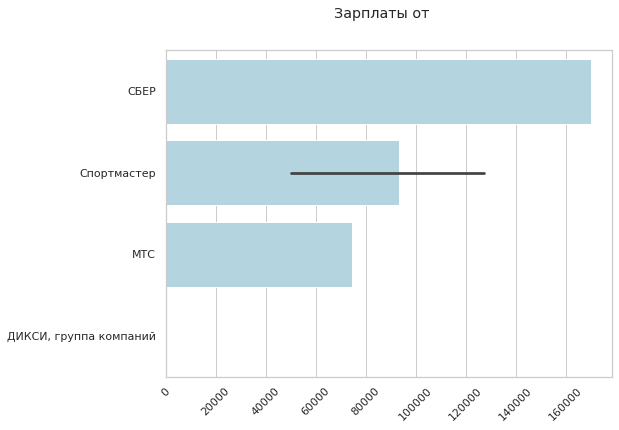

In [50]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(8, 6))                
sns.barplot(
    data=salaries.sort_values(by='salary_from', ascending=False),
    x='salary_from', y='employer_name', color='lightblue', orient='h',ax=ax)
fig.suptitle('Зарплаты от')
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.xticks(rotation=45);

In [51]:
vacancy_df.dropna(subset=['employer_name', 'salary_from'])[vacancy_df['employer_name']\
    .str.lower()
    .str.contains('спортмастер')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,response,city
123,70042646,False,Аналитик SQL (запуск промо),"{'id': '2343-2343-busi', 'name': 'Компания «СП...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 150000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кочновский пр.',...",...,False,between1And3,Спортмастер,"Компания «СПОРТМАСТЕР», Управление бизнесами",150000.0,NaN,True,RUR,NaN,Москва
958,69301532,False,Бизнес-аналитик,"{'id': '2343-2343-rozn', 'name': 'Компания «СП...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 80000, 'to': 120000, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",None,...,False,between1And3,Спортмастер,"Компания «СПОРТМАСТЕР», Розничные продажи",80000.0,120000.0,False,RUR,NaN,Москва
1053,68431025,False,Аналитик (цепи поставок),"{'id': '2343-2343-logi', 'name': 'Компания «СП...",False,False,"{'id': '2087', 'name': 'Железнодорожный', 'url...","{'from': 50000, 'to': 70000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",None,...,False,between1And3,Спортмастер,"Компания «СПОРТМАСТЕР», Логистика",50000.0,70000.0,False,RUR,NaN,Железнодорожный


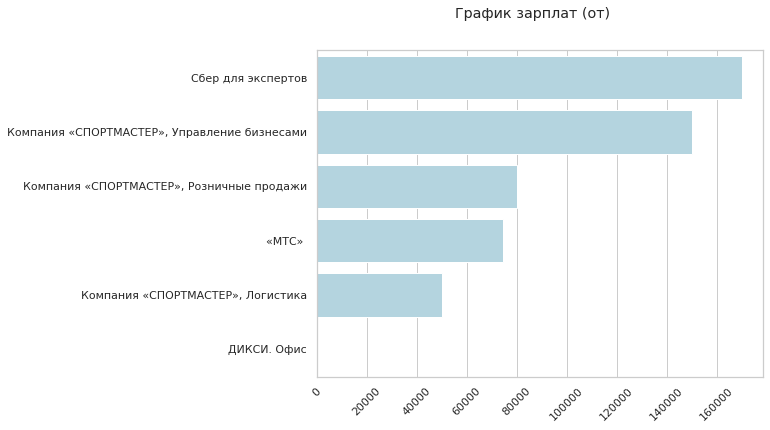

In [52]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(8, 6))                
sns.barplot(
    data=salaries.sort_values(by='salary_from', ascending=False),
    x='salary_from', y='department_name', color='lightblue', orient='h', ax=ax)
fig.suptitle('График зарплат (от)')
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.xticks(rotation=45);

### Поиск вакансий

Все вакансии в городах из списка CITIES.

In [53]:
CITIES = ['Москва', 'Санкт-Петербург']
vacancies_filt_1_df = vacancy_df[vacancy_df.city.isin(CITIES)]
print('Вего вакансий:', len(vacancies_filt_1_df), '\n')
vacancies_filt_1_df.head()

Вего вакансий: 1407 



,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,response,city
0,69982637,False,Разработчик DWH,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Профсоюзная улиц...",...,False,noExperience,РСХБ-Интех,NaN,NaN,NaN,NaN,NaN,NaN,Москва
1,70025793,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Головинское шосс...",...,False,noExperience,Тинькофф,NaN,NaN,NaN,NaN,NaN,NaN,Москва
2,70057994,False,Аналитик (стажёр),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Большая Новодмит...",...,False,noExperience,Лига Цифровой Экономики,NaN,NaN,NaN,NaN,NaN,NaN,Москва
3,69624831,False,Младший аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 50000, 'to': 55000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",None,...,False,noExperience,mnews,NaN,50000.0,55000.0,False,RUR,NaN,Москва
4,70029179,False,Бизнес аналитик/Data аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 150000, 'to': 170000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}",None,...,False,noExperience,Odgers Berndtson,NaN,150000.0,170000.0,True,RUR,NaN,Москва


### Содержание вакансий

In [54]:
vacancies_filt_2_df = vacancies_filt_1_df.copy().reset_index(drop=True).query("experience in ['noExperience', 'between1And3']")
print('Всего вакансий', len(vacancies_filt_2_df), '\n')
vacancies_filt_2_df.head()

Всего вакансий 809 



,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,response,city
0,69982637,False,Разработчик DWH,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Профсоюзная улиц...",...,False,noExperience,РСХБ-Интех,NaN,NaN,NaN,NaN,NaN,NaN,Москва
1,70025793,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Головинское шосс...",...,False,noExperience,Тинькофф,NaN,NaN,NaN,NaN,NaN,NaN,Москва
2,70057994,False,Аналитик (стажёр),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Большая Новодмит...",...,False,noExperience,Лига Цифровой Экономики,NaN,NaN,NaN,NaN,NaN,NaN,Москва
3,69624831,False,Младший аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 50000, 'to': 55000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",None,...,False,noExperience,mnews,NaN,50000.0,55000.0,False,RUR,NaN,Москва
4,70029179,False,Бизнес аналитик/Data аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 150000, 'to': 170000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}",None,...,False,noExperience,Odgers Berndtson,NaN,150000.0,170000.0,True,RUR,NaN,Москва


In [55]:
vacancies_filt_2_df['url'].head()

0    https://api.hh.ru/vacancies/69982637?host=hh.ru
1    https://api.hh.ru/vacancies/70025793?host=hh.ru
2    https://api.hh.ru/vacancies/70057994?host=hh.ru
3    https://api.hh.ru/vacancies/69624831?host=hh.ru
4    https://api.hh.ru/vacancies/70029179?host=hh.ru
Name: url, dtype: object

Информация о вакансии в читаемом виде

In [56]:
HTML(json.loads(requests.get('https://api.hh.ru/vacancies/69982637?host=hh.ru').text)['description'])

In [57]:
vacancy_descriptions = vacancies_filt_2_df['url'].apply(lambda x: HTML(json.loads(requests.get(x).text)['description']))
vacancy_descriptions

0      <IPython.core.display.HTML object>
1      <IPython.core.display.HTML object>
2      <IPython.core.display.HTML object>
3      <IPython.core.display.HTML object>
4      <IPython.core.display.HTML object>
                      ...                
804    <IPython.core.display.HTML object>
805    <IPython.core.display.HTML object>
806    <IPython.core.display.HTML object>
807    <IPython.core.display.HTML object>
808    <IPython.core.display.HTML object>
Name: url, Length: 809, dtype: object

Добавим интерактив.

In [58]:
button_prev = widgets.Button(description=' < ')
button_next = widgets.Button(description=' > ')
output = widgets.Output()

display(button_prev, button_next, output)

counter = -1
number = len(vacancies_filt_2_df)

def display_vacancy():
    print('Вакансия №', counter, '/', number - 1)
    display(HTML("<h1>" + str(vacancies_filt_2_df['name'][counter]) + ' в ' + str(vacancies_filt_2_df['employer_name'][counter]) + "</h1>"))
    display(vacancy_descriptions[counter])
    display(HTML('<a href="' + str(vacancies_filt_2_df['alternate_url'][counter]) + '" target="_blank">Ссылка на вакансию</a>'))

def prev(b):
    global counter
    with output:
        if counter < 1:
            counter = 1
        counter -= 1
        clear_output()
        display_vacancy()

def next(b):
    global counter
    with output:
        if counter > number - 2:
            counter = number - 2
        counter += 1
        clear_output()
        display_vacancy()

button_prev.on_click(prev)
button_next.on_click(next)

Button(description=' < ', style=ButtonStyle())

Button(description=' > ', style=ButtonStyle())

Output()

Текст из html.

In [59]:
text = vacancies_filt_2_df['url'].apply(lambda x: BeautifulSoup(json.loads(requests.get(x).text)['description']).get_text())
text

0      "РСХБ-Интех" — российская ИТ-компания, оказыва...
1      Что предстоит делать   Написание и поддержка м...
2      Проект в области eCommerce, а именно интернет-...
3      Ищем специалиста по Excel с навыками работы с ...
4      Мы в Odgers Berndtson Russia ищем, оцениваем и...
                             ...                        
804    Обязанности:   Разработка бизнес требований на...
805    Работать с лидером - быть лидером!Банк ВТБ акт...
806    Обязанности:   Участие в проекте внедрения обл...
807    Исследуйте, анализируйте и проектируйте бизнес...
808    ФБУ «ГИЛС и НП» является единственной в стране...
Name: url, Length: 809, dtype: object